data normalization ok
batch normalization ok
momentum learning rate ok
learning rate decay ok
weight initialize ok
dropout ok
weight regularization ok
early stopping ok


weight pruning
focal loss
penalty

In [243]:
#importing libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [244]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [245]:
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [246]:
# load dataset
data = pd.read_csv("dataset/preprocessed.csv")

In [247]:
data = data.drop(data[data.target == -1].index)
data.shape

(762094, 44)

In [248]:
# Separate input features and target
targets = data.target
targets -= 1


In [249]:
targets = targets.to_numpy()

In [250]:
features = data.drop('target', axis=1)

In [251]:
features = features.to_numpy()

In [252]:
# split test part
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 0)

In [253]:
# split train and validation part
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size = 0.2, random_state = 0)

In [254]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [ 50166  55949  87609 117459 176557]]


Text(0.5, 1.0, 'Unbalanced Data Distribution')

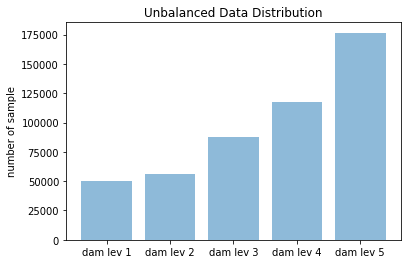

In [255]:
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('Unbalanced Data Distribution')

In [256]:
# sm = SMOTETomek(random_state = 27, n_jobs = -1)
# 
# X_train, y_train = sm.fit_sample(X_train, y_train)

In [257]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [ 50166  55949  87609 117459 176557]]


Text(0.5, 1.0, 'After Re-sampling Data Distribution')

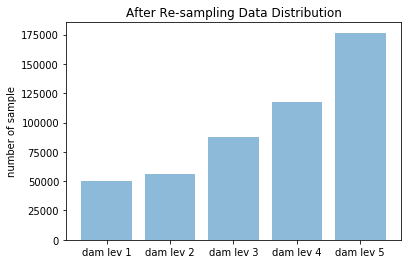

In [258]:
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('After Re-sampling Data Distribution')

In [259]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)


/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [260]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = torch.from_numpy(class_weights)
class_weights



tensor([1.9445, 1.7435, 1.1134, 0.8305, 0.5525], dtype=torch.float64)

In [261]:
import sys
epsilon = sys.float_info.epsilon

batch_size = 100000
epochs = 10
input_dim = 43
output_dim = 5
lr = 0.01
momentum_val = 0.9
weight_decay_val = 0.0001

gamma_val = 0.5
prob = 0.05


old_loss = 1 / epsilon
cur_loss = 0.0
best_loss = 1 / epsilon

loss_dicrease_count = 0
loss_dicrease_limit = 10
loss_dicrease_threshold = 0.001

early_stop_epoch = 0

In [262]:
class datasetLoad(Dataset):
    def __init__(self, features,labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [263]:
X_train = datasetLoad(X_train, y_train)
X_val = datasetLoad(X_val, y_val)


In [264]:
train_loader = torch.utils.data.DataLoader(dataset = X_train, batch_size = batch_size, shuffle=True, num_workers = 1)
val_loader = torch.utils.data.DataLoader(dataset = X_val, batch_size = batch_size, shuffle=True, num_workers = 1)



In [265]:
class FocalLoss(nn.Module):

    def __init__(self, focusing_param = 2, balance_param=0.5):
        super(FocalLoss, self).__init__()

        self.focusing_param = focusing_param
        self.balance_param = balance_param

    def forward(self, output, target):

        cross_entropy = F.cross_entropy(output, target)
        cross_entropy_log = torch.log(cross_entropy)
        logpt = - F.cross_entropy(output, target)
        pt    = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.focusing_param) * logpt

        balanced_focal_loss = self.balance_param * focal_loss

        return balanced_focal_loss
      

In [266]:

class neuralNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, output_dim, dropout_p):
        super(neuralNetwork, self).__init__()
        
        self.hidden1 = nn.Linear(input_dim, hidden1_dim, bias=True) 
        torch.nn.init.xavier_uniform(self.hidden1.weight)
        self.bnhidden1 = nn.BatchNorm1d(hidden1_dim)
        
        self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim, bias=True) 
        torch.nn.init.xavier_uniform(self.hidden2.weight)
        self.bnhidden2 = nn.BatchNorm1d(hidden2_dim)
        
        self.output = nn.Linear(hidden2_dim, output_dim, bias=True)
        torch.nn.init.xavier_uniform(self.output.weight)

        self.dropout = nn.Dropout(dropout_p)
    def forward(self, x):
        
        x = self.hidden1(x)   
        x = self.dropout(x)
        x = self.bnhidden1(x)        
        x = F.leaky_relu_(x, negative_slope=0.01)
        
        x = self.hidden2(x)        
        x = self.dropout(x)
        x = self.bnhidden2(x)
        x = F.leaky_relu_(x, negative_slope=0.01)
        
        
        outputs = self.output(x)
        return outputs

In [267]:
model = neuralNetwork(input_dim, 20, 10, output_dim, prob)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # Remove the CWD from sys.path while we load stuff.
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [268]:
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.CrossEntropyLoss(weight = class_weights.float())
# criterion = FocalLoss()


In [269]:
from torch.optim.lr_scheduler import MultiStepLR

optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum_val, weight_decay = weight_decay_val)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = MultiStepLR(optimizer, milestones=[100, 500, 1000, 1500], gamma = gamma_val)

In [270]:
if torch.cuda.is_available():
    print("cuda")
    model = model.cuda()
    criterion = criterion.cuda()

cuda


In [271]:
feature_train, label_train = next(iter(train_loader))
if torch.cuda.is_available():
    feature_train = feature_train.cuda()
grid_train = torchvision.utils.make_grid(feature_train)



In [272]:
tb = SummaryWriter('runs')

In [273]:
tb.add_image("features", grid_train)
tb.add_graph(model, feature_train.float())

In [ ]:
import datetime
a = datetime.datetime.now().replace(microsecond=0)
train_loss = []
validation_loss = []
for epoch in range(epochs):
    train_loss_val = 0.0
    train_counter = 0
    validation_loss_val = 0.0
    val_counter = 0
    accuracy = 0.0
    for i, (features_train, labels_train) in enumerate(train_loader):
        features_train = Variable(features_train)
        labels_train = Variable(labels_train)
        if torch.cuda.is_available():
            features_train = features_train.cuda()
            labels_train = labels_train.cuda()        
        optimizer.zero_grad()
        outputs_train = model(features_train.float())
        loss_train = criterion(outputs_train.float(), labels_train)
        loss_train.backward()
        optimizer.step()
        train_loss_val += loss_train.item()
        train_counter += 1
        del features_train
        del labels_train        
        torch.cuda.empty_cache()
        
    train_loss_val /= train_counter    
    
        
    for i, (features_val, labels_val) in enumerate( val_loader):
        features_val = Variable(features_val)
        labels_val = Variable(labels_val)
        if torch.cuda.is_available():
            features_val = features_val.cuda()
            labels_val = labels_val.cuda() 
        with torch.no_grad():
            outputs_val = model(features_val.float())
        loss = criterion(outputs_val.float(), labels_val)
        validation_loss_val += loss.item()
        _, predicted = torch.max(outputs_val.data, 1)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        accuracy += f1_score(labels_val.cpu(), predicted.cpu(), average = 'macro') * 100
        val_counter += 1
        del features_val
        del labels_val          
        torch.cuda.empty_cache()
        
    validation_loss_val /= val_counter
    accuracy /=  val_counter
        
        
    cur_loss = validation_loss_val
    
    if(cur_loss < best_loss):
        torch.save(model.state_dict(), 'weights_only.pth')
        early_stop_epoch = epoch
        best_loss = cur_loss
        
    if(cur_loss > old_loss + loss_dicrease_threshold):
        loss_dicrease_count += 1
        
    if(cur_loss + loss_dicrease_threshold < old_loss):
        loss_dicrease_count = 0
        
    if(loss_dicrease_count == loss_dicrease_limit):
        print("--------------------\n\n\nYOU NEED STOP\n\n\n\n----------")
        break
    
    old_loss = cur_loss
       
    scheduler.step()
     
    
    train_loss.append(train_loss_val)
    validation_loss.append(validation_loss_val)
    if(epoch % 5 == 0):
        print("{")
        print("Epoch: {}. Train Loss: {}. ".format(epoch, train_loss_val))
        print("Epoch: {}. Validation Loss: {}. Validation Accuracy: {}.".format(epoch, validation_loss_val, accuracy))
        print("}")
        
    tb.add_scalar("Train Loss ", train_loss_val, epoch)
    tb.add_scalar("Validation Loss ", validation_loss_val, epoch)
    tb.add_scalar("Validation Accur ", accuracy, epoch) 
        
    for name, weight in model.named_parameters():
        tb.add_histogram(name, weight, epoch)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch)
    
tb.close()

{
Epoch: 0. Train Loss: 1.8146912813186646. 
Epoch: 0. Validation Loss: 1.7826182842254639. Validation Accuracy: 17.27101327109996.
}


In [ ]:
b = datetime.datetime.now().replace(microsecond=0)
print(b-a)
import os,time
counter = 0
while(counter < 1):
    os.system('spd-say "your program has finished"')
    time.sleep(3)
    counter += 1

In [ ]:
# plotting the training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
x = np.full([2], early_stop_epoch, dtype = int)
y = np.linspace(min(train_loss), max(validation_loss), 2) 
plt.plot(x, y, '-r', label='Early stopping Line')
plt.title('Train and Validation Loss')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.legend(loc='upper left')
plt.legend()
plt.grid()
# plt.show()
plt.savefig("loss.png")


In [ ]:
print(early_stop_epoch)
the_model = neuralNetwork(input_dim, 20, 10, output_dim, prob)

In [ ]:
if torch.cuda.is_available():
    print("cuda")
    the_model = the_model.cuda()

In [ ]:
the_model.load_state_dict(torch.load("weights_only.pth"))

In [ ]:
X_test  = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [ ]:
if torch.cuda.is_available():
    print("cuda")
    X_test = X_test.cuda()
    y_test = y_test.cuda() 

In [ ]:
with torch.no_grad():
    outputs = the_model(X_test.float())
    # outputs = model(X_test.float())
_, predicted = torch.max(outputs.data, 1)


In [ ]:
print("Accuracy: \t", accuracy_score(y_test.cpu(), predicted.cpu()))
print("F1 Score: \t", f1_score(y_test.cpu(), predicted.cpu(), average = 'macro'))
print("Precision:\t", precision_score(y_test.cpu(), predicted.cpu(), average = 'macro'))
print("Recall:   \t", recall_score(y_test.cpu(), predicted.cpu(), average = 'macro'))

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.cpu(), predicted.cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest',cmap="RdYlGn")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(5):
    for j in range(5):
        plt.text(j,i,format(cm[i][j],".2f"),horizontalalignment="center",color="black")
plt.tight_layout()
# plt.show()
plt.savefig("confusion.png")



